In [ ]:
!pip install --upgrade gensim --quiet
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [ ]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

In [ ]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
raw_table_data.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


In [ ]:
def get_sentence_embedding(sentence):
    #words = sentence.split()
    words = sentence.lower().split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

In [ ]:
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']


In [ ]:
qwe = raw_table_data[columns_to_filter].quantile(0.99)

In [ ]:
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < qwe).all(axis=1)]

Auto ML H2O

In [ ]:
# Убираем из датасета лишние столбцы
# Формируем датасет для AutoML методов
autoML_df = full_df_filtered[['Count_subj', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()


In [ ]:
!pip install h2o --quiet

In [ ]:
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 33 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_5s2gxv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Переводим датафрейм в формат H2OFrame
h2o_df = H2OFrame(autoML_df)

# Разбиение на обучающую и тестовую выборки
random_seed = 17
train, test = h2o_df.split_frame(ratios=[0.85], seed=random_seed)

# Определяем целевую переменную и предикторы
y="Healthy_Status"
x = list(h2o_df.columns)
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Создаем и обучаем модель H2O AutoML
automl = H2OAutoML(max_runtime_secs=60, seed=random_seed, verbosity="info")
#automl= H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


automl.train(x=x, y=y, training_frame=train)

# Оценка модели на тестовом наборе
performance = automl.leader.model_performance(test_data=test)
print(performance)

AutoML progress: |
19:51:52.997: Project: AutoML_1_20250513_195152
19:51:53.0: 5-fold cross-validation will be used.
19:51:53.1: Setting stopping tolerance adaptively based on the training frame: 0.018579146207522112
19:51:53.1: Build control seed: 17
19:51:53.3: training frame: Frame key: AutoML_1_20250513_195152_training_py_2_sid_836b    cols: 10    rows: 2897  chunks: 1    size: 50294  checksum: 6164504805833964044
19:51:53.4: validation frame: NULL
19:51:53.5: leaderboard frame: NULL
19:51:53.6: blending frame: NULL
19:51:53.6: response column: Healthy_Status
19:51:53.6: fold column: null
19:51:53.7: weights column: null
19:51:53.40: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g, 10w)]}, {DeepLearning : [d

In [ ]:
lb = automl.leaderboard
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20250513_195152,0.360287,0.129807,0.269711,0.253126,0.129807
StackedEnsemble_BestOfFamily_3_AutoML_1_20250513_195152,0.36048,0.129946,0.269678,0.253221,0.129946
StackedEnsemble_AllModels_1_AutoML_1_20250513_195152,0.360717,0.130116,0.269851,0.25332,0.130116
StackedEnsemble_BestOfFamily_2_AutoML_1_20250513_195152,0.361192,0.13046,0.270797,0.253657,0.13046
GBM_3_AutoML_1_20250513_195152,0.361851,0.130936,0.275193,0.254815,0.130936
GBM_2_AutoML_1_20250513_195152,0.363099,0.131841,0.276752,0.255271,0.131841
GBM_4_AutoML_1_20250513_195152,0.365223,0.133388,0.272157,0.256198,0.133388
GBM_5_AutoML_1_20250513_195152,0.36523,0.133393,0.281727,0.256673,0.133393
DRF_1_AutoML_1_20250513_195152,0.366867,0.134591,0.265444,0.257165,0.134591
StackedEnsemble_BestOfFamily_1_AutoML_1_20250513_195152,0.366907,0.13462,0.281809,0.258068,0.13462


In [ ]:
model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['StackedEnsemble_AllModels_2_AutoML_1_20250513_195152',
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20250513_195152',
 'StackedEnsemble_AllModels_1_AutoML_1_20250513_195152',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20250513_195152',
 'GBM_3_AutoML_1_20250513_195152',
 'GBM_2_AutoML_1_20250513_195152',
 'GBM_4_AutoML_1_20250513_195152',
 'GBM_5_AutoML_1_20250513_195152',
 'DRF_1_AutoML_1_20250513_195152',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20250513_195152',
 'GBM_1_AutoML_1_20250513_195152',
 'XRT_1_AutoML_1_20250513_195152',
 'XGBoost_3_AutoML_1_20250513_195152',
 'XGBoost_grid_1_AutoML_1_20250513_195152_model_1',
 'GBM_grid_1_AutoML_1_20250513_195152_model_1',
 'DeepLearning_1_AutoML_1_20250513_195152',
 'GBM_grid_1_AutoML_1_20250513_195152_model_2',
 'XGBoost_1_AutoML_1_20250513_195152',
 'XGBoost_2_AutoML_1_20250513_195152',
 'GLM_1_AutoML_1_20250513_195152',
 'XGBoost_grid_1_AutoML_1_20250513_195152_model_2']

In [ ]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'silent': True,
  'eta': 0.3,
  'colsample_bylevel': 0.8,
  'objective': 'reg:squarederror',
  'min_child_weight': 3.0,
  'nthread': 2,
  'seed': 28,
  'max_depth': 5,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 27,
  'subsample': 0.8,
  'max_delta_step': 0.0,
  'tree_method': 'exact'},
 27)

In [ ]:
automl.leader.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.12107082565824845
RMSE: 0.3479523324512259
MAE: 0.2573252947559286
RMSLE: 0.24798862666292143
Mean Residual Deviance: 0.12107082565824845
R^2: 0.36418352558668643
Null degrees of freedom: 507
Residual degrees of freedom: 500
Null deviance: 97.12591185887521
Residual deviance: 61.50397943439021
AIC: 387.06072888251373

In [ ]:
test_predict = automl.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
# H2OFrame
test_preds = h2o.as_list(test_predict)
test_preds = test_preds['predict']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
test_Y = h2o.as_list(test['Healthy_Status'])
test_Y = test_Y['Healthy_Status']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Confusion matrix:
 [[319  59]
 [ 43  87]]
Accuracy: 0.80
F1-Score: 0.63
Recall:  0.67
Precision: 0.60
ROC-AUC: 0.88


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


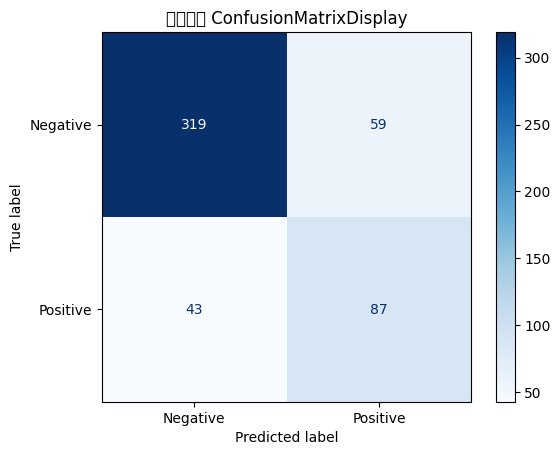

In [ ]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# 二值化预测结果（如果是概率形式）
test_preds = np.array(test_preds)  # 确保是 numpy 数组
test_preds_bin = np.where(test_preds > 0.5, 1, 0)

# 混淆矩阵
cm = confusion_matrix(test_Y, test_preds_bin)
TN, FP, FN, TP = cm.ravel()

# 评估指标
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FN + FP)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
roc_auc = roc_auc_score(test_Y, test_preds)

# 打印结果
print("Confusion matrix:\n", cm)
print("Accuracy:", "{:.2f}".format(accuracy))
print("F1-Score:", "{:.2f}".format(f1))
print("Recall: ", "{:.2f}".format(recall))
print("Precision:", "{:.2f}".format(precision))
print("ROC-AUC:", "{:.2f}".format(roc_auc))

# 可视化：sklearn 官方方式
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("混淆矩阵 ConfusionMatrixDisplay")
plt.grid(False)
plt.show()


In [ ]:
# Завершение работы H2O
h2o.shutdown()

H2O session _sid_836b closed.


<ipython-input-28-9ae954ad13ba>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


AutoML LightAutoML

In [ ]:
!pip install shap --quiet

In [ ]:
%%time
!pip install -U lightautoml --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
 

In [ ]:
# Импорт библиотек для auto ml
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch

import pandas as pd
import numpy as np

In [ ]:
N_THREADS = 4 #number of vCPUs for LightAutoML model creation
N_FOLDS = 2 # number of folds in LightAutoML inner CV
#All models that are trained during the cross-validation loop
#on different folds are then saved for the inference phase.
#Inference on new data is made by averaging models from all train folds.

RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 100 # Time in seconds for automl run
TARGET_NAME = 'Healthy_Status' # Target column name

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
train_data, test_data = train_test_split(
    autoML_df,
    test_size=TEST_SIZE,
    stratify=autoML_df[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (2724, 10), test_data = (681, 10)


,Count_subj,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
924,19,714,166,234,328,672,45,-37,117,0
1664,11,833,160,222,318,582,67,16,48,1
177,4,779,176,258,352,664,66,8,52,0
352,28,714,160,192,282,604,49,-40,19,0
836,2,779,154,164,256,526,50,55,26,0


In [ ]:
#The following task types are available:
#'binary' - for binary classification.
#'reg’ - for regression.
#‘multiclass’ - for multiclass classification.
#'multi:reg - for multiple regression.
#'multilabel' - for multi-label classification.

task = Task('binary')

In [ ]:
roles = {
    'target': TARGET_NAME
    #'category': TARGET_NAME
    #'drop': ['name of column']
}

In [ ]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 2)

[20:02:36] Stdout logging level is INFO2.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO2.


[20:02:36] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[20:02:36] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[20:02:36] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[20:02:36] - time: 100.00 seconds


INFO:lightautoml.automl.presets.base:- time: 100.00 seconds


[20:02:36] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[20:02:36] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[20:02:36] Train data shape: (2724, 10)



INFO:lightautoml.reader.base:Train data shape: (2724, 10)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[20:02:48] Layer 1 train process start. Time left 87.90 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 87.90 secs


[20:02:48] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0], 'embed_sizes': array([11], dtype=int32), 'data_size': 17}


[20:02:48] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7283839137844772
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7315557267879741
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7352412370472039
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.7532888664146339
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.7642076086054993
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.7982266742651052
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.8134315779334922
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.8361278999146513
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.

[20:02:50] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7180778625913351
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7222128579493313
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7266434967800278
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.7500140464093364
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.7655560639017983
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8080484587744575
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.8261937441306075
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.8496766650346077
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.

[20:02:51] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8484405810130004


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8484405810130004


[20:02:51] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[20:02:51] Time left 84.69 secs



INFO:lightautoml.automl.base:Time left 84.69 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.850495
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.860759
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.865221
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.867121
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.868293
INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.868239
INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.868218
INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.86771
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[670]	valid's auc: 0.868461


[20:02:52] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[20:02:52] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[20:02:52] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.855466
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.85869
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.86181
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.861687
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.861489
INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.861371
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[417]	valid's auc: 0.86227


[20:02:52] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.870326
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.872394
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.871383
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[167]	valid's auc: 0.87286


[20:02:53] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8625853152148031


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8625853152148031


[20:02:53] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[20:02:53] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 13.68 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 13.68 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-a13541f9-d43e-4170-8edb-58d96a3f768e
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.860157
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.860938
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[32]	valid's auc: 0.862233
INFO:optuna.study.study:Trial 0 finished with value: 0.8622328172281217 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.86223281

[20:03:06] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[20:03:06] The set of hyperparameters {'feature_fraction': 0.6099470674221126, 'num_leaves': 144, 'bagging_fraction': 0.993388667319079, 'min_sum_hessian_in_leaf': 1.3941165518456249, 'reg_alpha': 0.1290402830180643, 'reg_lambda': 9.61381188507591}
 achieve 0.8640 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6099470674221126, 'num_leaves': 144, 'bagging_fraction': 0.993388667319079, 'min_sum_hessian_in_leaf': 1.3941165518456249, 'reg_alpha': 0.1290402830180643, 'reg_lambda': 9.61381188507591}
 achieve 0.8640 auc


[20:03:06] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 144, 'feature_fraction': 0.6099470674221126, 'bagging_fraction': 0.993388667319079, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.1290402830180643, 'reg_lambda': 9.61381188507591, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 1.3941165518456249}


[20:03:06] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.862468
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[90]	valid's auc: 0.863097


[20:03:07] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.868237
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[57]	valid's auc: 0.870073


[20:03:07] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.864726054885341


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.864726054885341


[20:03:07] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[20:03:07] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[20:03:07] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7057906	best: 0.7057906 (0)	total: 49.1ms	remaining: 24.5s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8494492	best: 0.8500700 (99)	total: 164ms	remaining: 647ms
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.8530451	best: 0.8531843 (187)	total: 293ms	remaining: 435ms
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.8536016	best: 0.8552337 (243)	total: 404ms	remaining: 267ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.8552336921
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 243
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 244 iterations.


[20:03:07] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7349309	best: 0.7349309 (0)	total: 1.37ms	remaining: 683ms
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8586155	best: 0.8682527 (40)	total: 112ms	remaining: 441ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.8682527069
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 40
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 41 iterations.


[20:03:08] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8452500394637215


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.8452500394637215


[20:03:08] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[20:03:08] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 46.67 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 46.67 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-20d3c890-bf54-43ba-a2f3-93754bfeb581
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7021078	best: 0.7021078 (0)	total: 1.35ms	remaining: 673ms
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8448393	best: 0.8448393 (100)	total: 113ms	remaining: 445ms
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.8524699	best: 0.8524699 (200)	total: 224ms	remaining: 333ms
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.8560069	best: 0.8560069 (300)	total: 322ms	remaining: 213ms
INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.8583747	best: 0.8583747 (400)	total: 420ms	remaining: 104ms
INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.8592951	best: 0.8593673 (475)	total: 538ms	remaining: 0us
INFO3:lightautoml.ml_algo.boost_cb:

[20:03:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[20:03:54] The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 9.646833927143268e-06, 'min_data_in_leaf': 13}
 achieve 0.8627 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 9.646833927143268e-06, 'min_data_in_leaf': 13}
 achieve 0.8627 auc


[20:03:54] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 9.646833927143268e-06, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 13, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[20:03:54] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7021078	best: 0.7021078 (0)	total: 1.49ms	remaining: 4.48s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8473757	best: 0.8473757 (100)	total: 143ms	remaining: 4.12s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.8527481	best: 0.8533876 (197)	total: 233ms	remaining: 3.25s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.8581018	best: 0.8583373 (297)	total: 325ms	remaining: 2.92s
INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.8580403	best: 0.8587145 (315)	total: 411ms	remaining: 2.66s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.8587145261
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 315
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 316 iterations.


[20:03:55] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6497133	best: 0.6497133 (0)	total: 1.17ms	remaining: 3.51s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8712734	best: 0.8716426 (99)	total: 87.8ms	remaining: 2.52s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.8716425737
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 99
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 100 iterations.


[20:03:55] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.8554631168045891


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.8554631168045891


[20:03:55] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[20:03:55] Time left 20.55 secs



INFO:lightautoml.automl.base:Time left 20.55 secs



[20:03:55] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[20:03:55] Blending: optimization starts with equal weights. Score = 0.8695242


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.8695242


[20:03:55] Blending: iteration 0: score = 0.8717014, weights = [0.25409755 0.2858948  0.35653645 0.         0.10347116]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.8717014, weights = [0.25409755 0.2858948  0.35653645 0.         0.10347116]


[20:03:55] Blending: iteration 1: score = 0.8723797, weights = [0.3059686  0.1195126  0.48029202 0.         0.09422675]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.8723797, weights = [0.3059686  0.1195126  0.48029202 0.         0.09422675]


[20:03:55] Blending: iteration 2: score = 0.8725904, weights = [0.31035653 0.         0.5961005  0.         0.09354302]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.8725904, weights = [0.31035653 0.         0.5961005  0.         0.09354302]


[20:03:55] Blending: iteration 3: score = 0.8726318, weights = [0.3234862 0.        0.5901463 0.        0.0863675]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = 0.8726318, weights = [0.3234862 0.        0.5901463 0.        0.0863675]


[20:03:56] Blending: iteration 4: score = 0.8726486, weights = [0.33102164 0.         0.56347    0.         0.1055084 ]


INFO:lightautoml.automl.blend:Blending: iteration 4: score = 0.8726486, weights = [0.33102164 0.         0.56347    0.         0.1055084 ]


[20:03:56] Blending: best score = 0.8726486, best weights = [0.33102164 0.         0.56347    0.         0.1055084 ]


INFO:lightautoml.automl.blend:Blending: best score = 0.8726486, best weights = [0.33102164 0.         0.56347    0.         0.1055084 ]


[20:03:56] Automl preset training completed in 79.98 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 79.98 seconds



[20:03:56] Model description:
Final prediction for new objects (level 0) = 
	 0.33102 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.56347 * (2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.10551 * (2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.33102 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.56347 * (2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.10551 * (2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



In [ ]:
test_predictions = automl.predict(test_data).data
#print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
#plt.plot(test_predictions.data[:],'.')

Confusion matrix: [[438  53]
 [ 95  95]]
F1-Score:  0.56
Accuracy: 0.78
Recall:  0.50
Precision:  0.64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


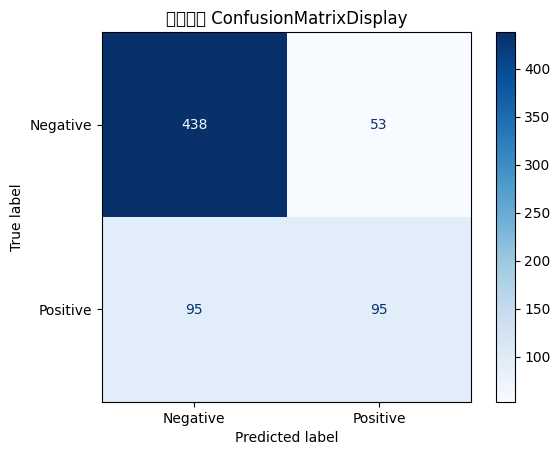

In [ ]:
# Порог отсечения - 0.5
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(len(test_predictions)):
  if test_predictions[i] > 0.5:
    test_predictions[i] = 1
  else:
    test_predictions[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(test_data['Healthy_Status'], test_predictions)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('混淆矩阵 ConfusionMatrixDisplay')
plt.grid(False)
plt.show()

In [ ]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.33102 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.56347 * (2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.10551 * (2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


GAMA


In [ ]:

!pip install gama --quiet

In [ ]:
from sklearn.metrics import log_loss, accuracy_score
from gama import GamaClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



Y_auto = autoML_df['Healthy_Status'] # таргет
X_auto = autoML_df.iloc[:, :8] # переменные

# Разбиваем данные на обучающую и тестовую выборки
RANDOM_SEED = 0

X_train, X_test, y_train, y_test = train_test_split(X_auto, Y_auto, train_size=0.70, random_state=RANDOM_SEED, stratify=Y_auto)
print('Распределение Y_train по классам 0 и 1 соответственно:', np.bincount(y_train))
print('Распределение Y_test по классам 0 и 1 соответственно:', np.bincount(y_test))


automl = GamaClassifier(max_total_time=60, store="nothing")
print("Starting `fit` which will take roughly 1 minutes.")
automl.fit(X_train, y_train)


label_predictions = automl.predict(X_test)
probability_predictions = automl.predict_proba(X_test)

print('accuracy:', accuracy_score(y_test, label_predictions))
print('log loss:', log_loss(y_test, probability_predictions))
# the `score` function outputs the score on the metric optimized towards (by default, `log_loss`)
print('log_loss', automl.score(X_test, y_test))


test_preds = label_predictions.data

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))